# Introduction to Regression Splines
https://www.analyticsvidhya.com/blog/2018/03/introduction-regression-splines-python-codes/

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## Understanding the data

In [3]:
data = pd.read_csv("data/Wage.csv")
data.head()

,ID,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


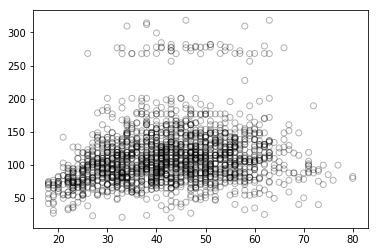

In [4]:
data_x = data['age']
data_y = data['wage']

# Dividing data into train and validation datasets
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)

# Visualize the relationship b/w age and wage
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()

## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression

# Fitting linear regression model
x = train_x.reshape(-1,1)
model = LinearRegression()
model.fit(x,train_y)
print(model.coef_)
print(model.intercept_)

[0.72190831]
80.6528774075928


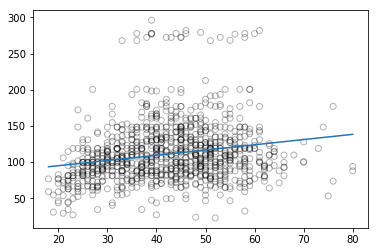

In [6]:
# Prediction on validation dataset
valid_x = valid_x.reshape(-1,1)
pred = model.predict(valid_x)

# Visualisation
# We will use 70 plots between minimum and maximum values of valid_x for plotting
xp = np.linspace(valid_x.min(),valid_x.max(),70)
xp = xp.reshape(-1,1)
pred_plot = model.predict(xp)

plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

We can now calculate the RMSE on the predictions.

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(valid_y, pred))
print(rms)

40.436687488017256


We can infer from the above graph that linear regression is not capturing all the signals available and is not the best method for solving this wage prediction.

Although linear models are relatively simple to describe and implement and have advantages over other approaches in terms of interpretation and inference, they have significant limitations in terms of predictive power. This is because they assume the linear combination between the dependent and independent variables which is almost always an approximation, and sometimes a poor one.

In the other methods we will see below, we will set aside the linearity assumption while still attempting to maintain as much interpretability as possible. We will do this by examining very simple extensions of linear models like polynomial regression and step functions, as well as more sophisticated approaches such as splines.

## Improvement over Linear Regression: Polynomial Regression

Polynomial regression extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power. For example, a cubic regression uses three variables $x^1, x^2, x^3$, as predictors. This approach provides a simple way to provide a non-linear fit to data.

The standard method to extend linear regression to a non-linear relationship between the dependent and independent variables, has been to replace the linear model with a polynomial function.

$$
\Large{
y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + ... + \beta_p x_i^p
}
$$

As we increase the power value, the curve obtained contains high oscillations which will lead to shapes that are over-flexible. Such curves lead to over-fitting.

In [8]:
# Generating weights for polynomial function with degree = 2
weights = np.polyfit(train_x, train_y, 2)
print(weights)

[ -0.05194765   5.22868974 -10.03406116]


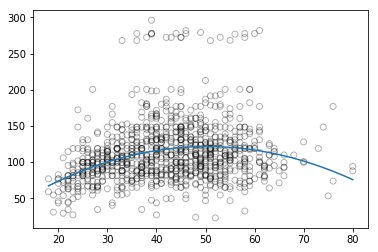

In [9]:
# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(valid_x)
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

Similarly, we can plot polynomial curves for different degree values.

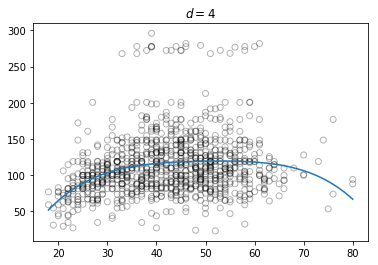

In [10]:
degrees = 4
weights = np.polyfit(train_x, train_y, degrees)

# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(valid_x)
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.title(f'$d={degrees}$')
plt.show()

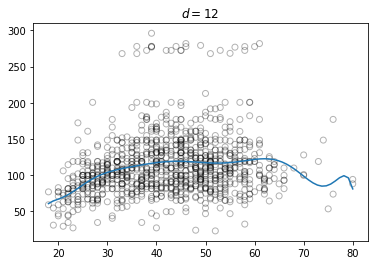

In [11]:
degrees = 12
weights = np.polyfit(train_x, train_y, degrees)

# Generating model with the given weights
model = np.poly1d(weights)

# Prediction on validation set
pred = model(valid_x)
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.title(f'$d={degrees}$')
plt.show()

Unfortunately, polynomial regression has a fair number of issues as well. As we increase the complexity of the formula, the number of features also increases which is sometimes difficult to handle. Also, polynomial regression has a tendency to drastically over-fit, even on this simple one dimensional data set.

There are other issues with polynomial regression. For example, it is inherently non-local, i.e., changing the value of Y at one point in the training set can affect the fit of the polynomial for data points that are very far away. Hence, to avoid the use of high degree polynomial on the whole dataset, we can substitute it with many different small degree polynomial functions.

## Regression Splines

In order to overcome the disadvantages of polynomial regression, we can use an improved regression technique which, instead of building one model for the entire dataset, divides the dataset into multiple bins and fits each bin with a separate model. Such a technique is known as Regression spline.

The points where the division occurs are called Knots. Functions which we can use for modelling each piece/bin are known as Piecewise functions. There are various piecewise functions that we can use to fit these individual bins.

### Piecewise Step Functions

One of the most common piecewise functions is a Step function. A step function is a function which remains constant within the interval. We can fit individual step functions to each of the divided portions in order to avoid imposing a global structure. Here we break the range of X into bins, and fit a different constant in each bin.

In greater detail, we create cut points C1 , C2, . . . , Ck  in the range of X, and then construct K  + 1 new variables.

In [12]:
# Dividing the data into 4 bins
# Allemaal ong. 15.5 jaar breed)
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]    504
(33.5, 49.0]      941
(49.0, 64.5]      511
(64.5, 80.0]       54
Name: age, dtype: int64

In [13]:
df_steps = pd.concat([train_x, df_cut, train_y], keys=['age','age_cuts','wage'], axis=1)
df_steps.head()

,age,age_cuts,wage
1382,49,"(33.5, 49.0]",117.146817
23,40,"(33.5, 49.0]",160.642475
2140,55,"(49.0, 64.5]",81.283253
1117,32,"(17.938, 33.5]",94.072715
933,42,"(33.5, 49.0]",75.043154


In [14]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
1382,0,1,0,0
23,0,1,0,0
2140,0,0,1,0
1117,1,0,0,0
933,0,1,0,0


In [15]:
# df_steps_dummies.columns = ['17.938-33.5','33.5-49','49-64.5','64.5-80']

# Fitting Generalised linear models
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()

# Binning validation set into same 4 bins
bin_mapping = np.digitize(valid_x, bins).reshape(1, -1)[0]

# Removing any outliers
X_valid = pd.get_dummies(bin_mapping).drop([5], axis=1)

# Prediction
pred2 = fit3.predict(X_valid)

# Calculating RMSE
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid_y, pred2)) 
print(rms) 

39.99060078311039


In [16]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping) 
pred2 = fit3.predict(X_valid_2)

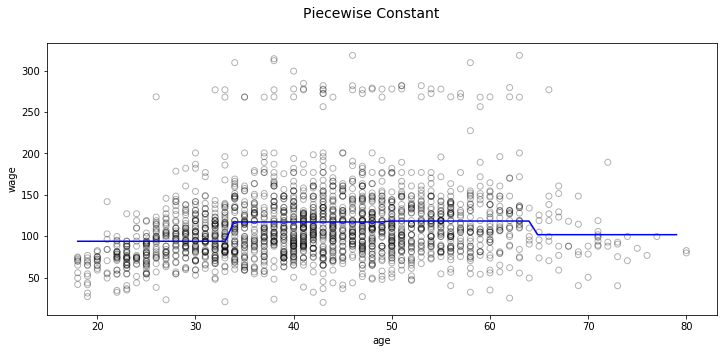

In [17]:
# Visualisation
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
plt.show()

Binning has its obvious conceptual issues. Most prominently, we expect most phenomena we study to vary continuously with inputs. **Binned regression does not create continuous functions of the predictor, so in most cases we would expect no relationship between the input and output.**

For example, in the above graph, we can see that the first bin clearly misses the increasing trend of wage with age.

### Basis Functions

To capture non-linearity in regression models, we need to transform some, or all of the predictors. To avoid having to treat every predictor as linear, we want to apply a very general family of transformations to our predictors. The family should be flexible enough to adapt (when the model is fit) to a wide variety of shapes, but not too flexible as to over-fit.

This concept of a family of transformations that can fit together to capture general shapes is called a basis function. In this case, our objects are functions: $b_1(x)$, $b_2(x)$, ..., $b_K(x)$.

Instead of fitting a linear model in X, we fit the below model:

$$\large{y_i = \beta_0 + \beta_1b_1(x_i) + \beta_2b_2(x_i) + \beta_3b_3(x_i) + ... + \beta_kb_k(x_i)}$$

Now we’ll look into a very common choice for a basis function: **Piecewise Polynomials**.

### Piecewise Polynomials

Instead of fitting a constant function over different bins across the range of X, piecewise polynomial regression involves fitting separate low-degree polynomials over different regions of X. As we use lower degrees of polynomials, we don’t observe high oscillations of the curve around the data.

For example, a piecewise quadratic polynomial works by fitting a quadratic regression equation:

$$\large{y_i = \beta_0 + \beta_1 x_i + \beta_2 {x_i}^2}$$

where the coefficients β0 , β1 and β2 differ in different parts of the range of X. 

A piecewise cubic polynomial, with a single knot at a point c, takes the below form:

$$
\large{
y_i = \left\{
\begin{align}
\beta_{01} + \beta_{11} x_i + \beta_{21} x_i^2 + \beta_{31} x_i^3 + \epsilon_i \quad \mathrm{if} \ x_i < c; \\
\beta_{02} + \beta_{12} x_i + \beta_{22} x_i^2 + \beta_{32} x_i^3 + \epsilon_i \quad \mathrm{if} \ x_i \ge c.
\end{align}
\right\}
}
$$

In other words, we fit two different polynomial functions to the data: one on the subset of the observations with xi < c, and one on the subset of the observations with xi ≥ c.

The first polynomial function has coefficients β01, β11, β21, β31 and the second has coefficients β02, β12, β22, β32. Each of these polynomial functions can be fit using the least squares error metric.

Remember that this family of polynomial functions has 8 degrees of freedom, 4 for each polynomial (as there are 4 variables).

Using more knots leads to a more flexible piecewise polynomial, as we use different functions for every bin. These functions depend only on the distribution of data of that particular bin. **In general, if we place K different knots throughout the range of X, we will end up fitting K+1 different cubic polynomials.** We can use any low degree polynomial to fit these individual bins. For example, we can instead fit piecewise linear functions. **In fact, the stepwise functions used above are actually piecewise polynomials of degree 0.**

Now we will look at some necessary conditions and constraints that should be followed while forming piecewise polynomials.

### Constraints and Splines

We need to be cautious while using Piecewise polynomials as there are various constraints that we need to follow. Consider the image below:

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/02/Screen-Shot-2018-02-22-at-5.08.07-PM.png" style="width: 360px;"/>

<center>*Source: Elements of Statistical Learning*</center>

We might encounter certain situations where the polynomials at either end of a knot are not continuous at the knot. Such a condition should be avoided because the family of polynomials as a whole should generate a unique output for every input.

We can see from the above image that it outputs two different values at the first knot. Thus, to avoid this, **we should add an extra constraint/condition that the polynomials on either side of a knot should be continuous at the knot.**

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/02/Screen-Shot-2018-02-22-at-5.31.22-PM.png" style="width: 360px;"/>

Now after adding that constraint, we get a continuous family of polynomials. But does it look perfect? Before reading further, take a moment to think about what’s missing here.

It looks like smoothness at the knots is still absent. **So to smoothen the polynomials at the knots, we add an extra constraint/condition: the first derivative of both the polynomials must be same.** One thing we should note: Each constraint that we impose on the piecewise cubic polynomials effectively frees up one degree of freedom, as we reduce the complexity of the resulting piecewise polynomial fit. Therefore, in the above plot, we are using only 10 degrees of freedom instead of 12.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/02/Screen-Shot-2018-02-22-at-5.47.59-PM.png" style="width: 360px;"/>

After imposing the constraint of equal first derivative, we obtain the above plot. This plot uses 8 degrees of freedom instead of 12 as two constraints are imposed. Although the above plot looks better, there is still some scope for improvement. Now, we will impose **an extra constraint: that the double derivatives of both the polynomials at a knot must be same.**

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/02/Screen-Shot-2018-02-22-at-5.57.57-PM.png" style="width: 360px;"/>

This plot seems perfect for our study. It uses 6 degrees of freedom instead of 12. Such a piecewise polynomial of degree m with m-1 continuous derivatives is called a **Spline**. Hence, we have constructed a Cubic Spline in the above plot. We can plot any degree of spline with m-1 continuous derivatives.

### Cubic Splines

Cubic spline is a piecewise polynomial with a set of extra constraints (continuity, continuity of the first derivative, and continuity of the second derivative). In general, a cubic spline with K knots uses cubic spline with a total of 4 + K degrees of freedom. There is seldom any good reason to go beyond cubic-splines (unless one is interested in smooth derivatives).

In [18]:
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
# Generating cubic spline with 3 knots at 25, 40 and 60
transformed_x = dmatrix("bs(train, knots=(25,40,60), degree=3, include_intercept=False)", {"train": train_x},return_type='dataframe')

transformed_x.head()

,Intercept,"bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[0]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[1]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[2]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[3]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[4]","bs(train, knots=(25, 40, 60), degree=3, include_intercept=False)[5]"
1382,1.0,0.000000,0.045272,0.536725,0.395222,0.022781,0.0
23,1.0,0.000000,0.272109,0.611008,0.116883,0.000000,0.0
2140,1.0,0.000000,0.004252,0.341933,0.548346,0.105469,0.0
1117,1.0,0.070523,0.598567,0.319030,0.011879,0.000000,0.0
933,1.0,0.000000,0.198367,0.632152,0.169231,0.000250,0.0


https://en.wikipedia.org/wiki/Design_matrix

In [20]:
# Fitting Generalised linear model on transformed dataset
fit1 = sm.GLM(train_y, transformed_x).fit()

In [21]:
# Generating cubic spline with 4 knots
transformed_x2 = dmatrix("bs(train, knots=(25,40,50,65),degree =3, include_intercept=False)", {"train": train_x}, return_type='dataframe')

# Fitting Generalised linear model on transformed dataset
fit2 = sm.GLM(train_y, transformed_x2).fit()

In [22]:
# Predictions on both splines
pred1 = fit1.predict(dmatrix("bs(valid, knots=(25,40,60), include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))
pred2 = fit2.predict(dmatrix("bs(valid, knots=(25,40,50,65),degree =3, include_intercept=False)", {"valid": valid_x}, return_type='dataframe'))

In [23]:
# Calculating RMSE values
rms1 = sqrt(mean_squared_error(valid_y, pred1))
print(rms1)
# -> 39.4

39.40318768341124


In [24]:
rms2 = sqrt(mean_squared_error(valid_y, pred2))
print(rms2)
# -> 39.3

39.34292609147628


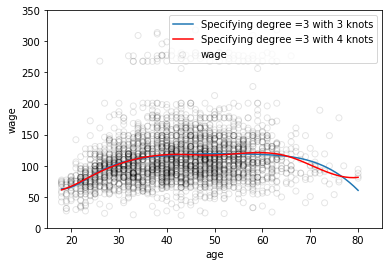

In [25]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)

# Make some predictions
pred1 = fit1.predict(
    dmatrix("bs(xp, knots=(25,40,60), include_intercept=False)", 
            {"xp": xp}, return_type='dataframe')
)
pred2 = fit2.predict(
    dmatrix("bs(xp, knots=(25,40,50,65),degree =3, include_intercept=False)", 
            {"xp": xp}, return_type='dataframe')
)

# Plot the splines and error bands
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred1, label='Specifying degree =3 with 3 knots')
plt.plot(xp, pred2, color='r', label='Specifying degree =3 with 4 knots')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

We know that the behavior of polynomials that are fit to the data tends to be erratic near the boundaries. Such variability can be dangerous. These problems are resembled by splines, too. The polynomials fit beyond the boundary knots behave even more wildly than the corresponding global polynomials in that region. **To smooth the polynomial beyond the boundary knots, we will use a special type of spline known as Natural Spline.**

### Natural Cubic Splines

A natural cubic spline adds additional constraints, namely that the function is linear beyond the boundary knots. This constrains the cubic and quadratic parts there to 0, each reducing the degrees of freedom by 2. That’s 2 degrees of freedom at each of the two ends of the curve, reducing K+4 to K.

In [26]:
# Generating natural cubic spline
transformed_x3 = dmatrix("cr(train,df = 3)", {"train": train_x}, return_type='dataframe')
fit3 = sm.GLM(train_y, transformed_x3).fit()

# Prediction on validation set
pred3 = fit3.predict(dmatrix("cr(valid, df=3)", {"valid": valid_x}, return_type='dataframe'))
# Calculating RMSE value
rms = sqrt(mean_squared_error(valid_y, pred3))
print(rms)
# -> 39.44

39.44823813743623


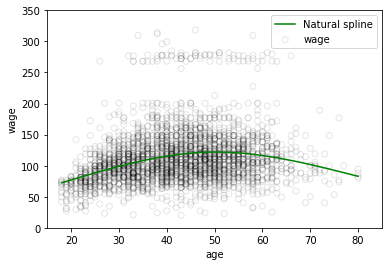

In [27]:
# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred3 = fit3.predict(dmatrix("cr(xp, df=3)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1)
plt.plot(xp, pred3,color='g', label='Natural spline')
plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
plt.show()

### Choosing the Number and Locations of the Knots

When we fit a spline, where should we place the knots? One potential place would be the area of high variability, because in those regions the polynomial coefficients can change rapidly. Hence, one option is to place more knots in places where we feel the function might vary most rapidly, and to place fewer knots where it seems more stable.

While this option can work well, in practice it is common to place knots in a uniform fashion. One way to do this is to specify the desired degrees of freedom, and then have the software automatically place the corresponding number of knots at uniform quantiles of the data.

Another option is to try out different numbers of knots and see which produces the best looking curve.

**A more objective approach is to use cross-validation.** With this method:

- we remove a portion of the data,
- fit a spline with a certain number of knots to the remaining data, and then,
- use the spline to make predictions for the held-out portion.

We repeat this process multiple times until each observation has been left out once, and then compute the overall cross-validated RMSE. This procedure can be repeated for different numbers of K knots. Then the value of K giving the smallest RMSE is chosen.

## Comparison of Regression Splines with Polynomial Regression

Regression splines often give better results than polynomial regression. This is because, unlike polynomials, which must use a high degree polynomial to produce flexible fits, splines introduce flexibility by increasing the number of knots but keep the degree fixed.

Generally, this approach produces more stable estimates. Splines also allow us to place more knots, and hence flexibility, over regions where the function seems to be changing rapidly, and fewer knots where the function appears more stable. The extra flexibility in the polynomial produces undesirable results at the boundaries, whereas the natural cubic spline still provides a reasonable fit to the data.

RMSE model 4: 39.35732797327388
RMSE model 5: 39.3851075773992


/opt/miniconda/envs/eda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


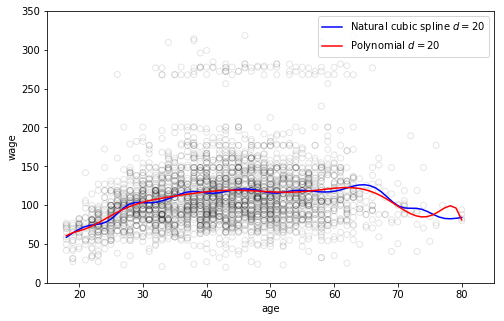

In [39]:
degrees = 20

plt.figure(figsize=(8,5))
plt.scatter(data.age, data.wage, facecolor='None', edgecolor='k', alpha=0.1, label=None)

######################
# Natural cubic spline
transformed_x4 = dmatrix("cr(train, df=degrees)", {"train": train_x}, return_type='dataframe')
fit4 = sm.GLM(train_y, transformed_x4).fit()

# Prediction on validation set
pred4 = fit4.predict(dmatrix("cr(valid, df=degrees)", {"valid": valid_x}, return_type='dataframe'))
# Calculating RMSE value
rms4 = sqrt(mean_squared_error(valid_y, pred4))
print('RMSE model 4:', rms4)
# -> 39.44

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred4p = fit4.predict(dmatrix("cr(xp, df=degrees)", {"xp": xp}, return_type='dataframe'))

# Plot the spline
plt.plot(xp, pred4p, color='b', label=f'Natural cubic spline $d={degrees}$')

#######################
# Polinomial regression
weights = np.polyfit(train_x, train_y, degrees)

# Generating model with the given weights
model5 = np.poly1d(weights)

# Prediction on validation set
pred5 = model(valid_x)
rms5 = sqrt(mean_squared_error(valid_y, pred5))
print('RMSE model 5:', rms5)

# We will plot the graph for 70 observations only
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred5p = model(xp)
plt.plot(xp, pred5p, color='r', label=f'Polynomial $d={degrees}$')

plt.legend()
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage')
# sns.despine()
plt.show()

## End Notes

In this article, we learned about regression splines and their benefits over linear and polynomial regression. Another method to produce splines is called **smoothing splines.** It works similar to Ridge/Lasso regularisation as it penalizes both loss function and a smoothing function. You can read more about it in the book ‘Introduction to Statistical learning’. You can implement these methods on datasets with high variability and notice the difference.

# Experiment

In [64]:
def nat_cubic_spline(train_x, train_y, valid_x, valid_y, deg=3):
    transformed_x = dmatrix("cr(train, df=deg)", {"train": train_x}, return_type='dataframe')
    model = sm.GLM(train_y, transformed_x).fit()

    pred = model.predict(dmatrix("cr(valid, df=deg)", {"valid": valid_x}, return_type='dataframe'))
    rmse = sqrt(mean_squared_error(valid_y, pred))
    return model, rmse

best_df = None
best_rmse = 99999
for i in range(3, 31):
    m, e = nat_cubic_spline(train_x, train_y, valid_x, valid_y, deg=i)
#     print(f'Degrees of freedom {i} RMSE: {e}')
    if e < best_rmse:
        best_rmse = e
        best_df = i
        model = m
        
print(f'Best result: {best_df} degrees of freedom. RMSE: {best_rmse}')

Best result: 13 degrees of freedom. RMSE: 39.24341552261858


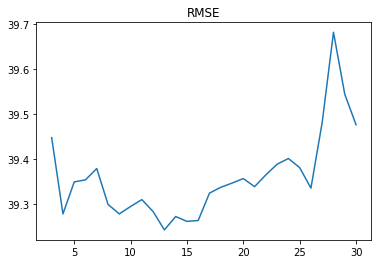

In [63]:
plt.plot(
    range(3, 31),
    [e for m, e in (nat_cubic_spline(train_x, train_y, valid_x, valid_y, deg=i) for i in range(3, 31))]
)
plt.title('RMSE');